# Differential gene expression analysis of naive versus primed

In [1]:
library(ggplot2)
library(dplyr)
library(readr)
library(DESeq2)
library(DiffBind)
library(tidyr)
library(wesanderson)
library(viridis)
library(gplots)
library(pheatmap)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    Filter,

In [2]:
setwd('/lustre1/project/stg_00041/Irene/bulkRNAseq_primed_naive_PRC2i_2020/featureCount/')

In [3]:
gene_counts <- read.delim("gene_raw_counts_ordered.txt")

In [4]:
head(gene_counts)

GeneID,primed_rep1,primed_rep2,primed_rep3,primed_PRC2i_rep1,primed_PRC2i_rep2,primed_PRC2i_rep3,naive_rep1,naive_rep2,naive_rep3,naive_PRC2i_rep1,naive_PRC2i_rep2,naive_PRC2i_rep3
DDX11L1,1,0,0,0,0,0,0,0,0,0,0,0
WASH7P,0,0,1,2,1,0,0,1,1,0,1,0
MIR6859-1,0,0,0,0,0,0,0,0,0,0,0,0
MIR1302-2HG,0,0,0,0,0,0,0,0,0,0,0,0
MIR1302-2,0,0,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
myvars_naive <- c("GeneID","primed_rep1","primed_rep2","primed_rep3","naive_rep1","naive_rep2","naive_rep3")

In [7]:
gene_counts_primed_naive <- gene_counts[myvars_naive]

In [8]:
head(gene_counts_primed_naive)

GeneID,primed_rep1,primed_rep2,primed_rep3,naive_rep1,naive_rep2,naive_rep3
DDX11L1,1,0,0,0,0,0
WASH7P,0,0,1,0,1,1
MIR6859-1,0,0,0,0,0,0
MIR1302-2HG,0,0,0,0,0,0
MIR1302-2,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0


In [9]:
rownames(gene_counts_primed_naive) <- gene_counts_primed_naive[,1]

In [10]:
gene_counts_primed_naive$GeneID <- NULL

In [11]:
head(gene_counts_primed_naive)

,primed_rep1,primed_rep2,primed_rep3,naive_rep1,naive_rep2,naive_rep3
DDX11L1,1,0,0,0,0,0
WASH7P,0,0,1,0,1,1
MIR6859-1,0,0,0,0,0,0
MIR1302-2HG,0,0,0,0,0,0
MIR1302-2,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0


In [12]:
gene_counts_primed_naive <- gene_counts_primed_naive[,c(4,5,6,1,2,3)]

In [13]:
condition <- factor(c("naive","naive","naive","primed","primed","primed"), levels = c("primed", "naive"))
print(condition)

[1] naive  naive  naive  primed primed primed
Levels: primed naive


In [14]:
colData <- data.frame(sampleName = colnames(gene_counts_primed_naive),
                      condition = condition)

In [15]:
colData

sampleName,condition
naive_rep1,naive
naive_rep2,naive
naive_rep3,naive
primed_rep1,primed
primed_rep2,primed
primed_rep3,primed


In [16]:
dds_unbiased <- DESeqDataSetFromMatrix(countData = gene_counts_primed_naive, 
                                       colData = colData, 
                                       design = ~ condition)

colnames(dds_unbiased) <- colnames(gene_counts_primed_naive)

In [17]:
dds_unbiased

class: DESeqDataSet 
dim: 59050 6 
metadata(1): version
assays(1): counts
rownames(59050): DDX11L1 WASH7P ... MT-TT MT-TP
rowData names(0):
colnames(6): naive_rep1 naive_rep2 ... primed_rep2 primed_rep3
colData names(2): sampleName condition

only keep rows that at least 2 conditions have >1 counts

In [18]:
dds_unbiased2 <- dds_unbiased[ rowSums(counts(dds_unbiased)>1) >=2, ]

In [19]:
dds_unbiased2

class: DESeqDataSet 
dim: 26808 6 
metadata(1): version
assays(1): counts
rownames(26808): CICP27 AL627309.6 ... MT-TT MT-TP
rowData names(0):
colnames(6): naive_rep1 naive_rep2 ... primed_rep2 primed_rep3
colData names(2): sampleName condition

In [20]:
dds_unbiased2$condition

[1] naive  naive  naive  primed primed primed
Levels: primed naive

In [21]:
dds2 <- DESeq(dds_unbiased2, betaPrior=FALSE)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [22]:
res_deseq2 <- results(dds2)

In [23]:
DEG_analysis <- res_deseq2[order(res_deseq2$log2FoldChange),]

In [24]:
head(DEG_analysis)

log2 fold change (MLE): condition naive vs primed 
Wald test p-value: condition naive vs primed 
DataFrame with 6 rows and 6 columns
                  baseMean    log2FoldChange            lfcSE              stat
                 <numeric>         <numeric>        <numeric>         <numeric>
LINC00836 580.429371447865 -12.4952125654457 1.25553825453133 -9.95207634681746
NMNAT1P3  213.196897376583 -11.0492169810533 1.19220029781129 -9.26791999745183
IGSF21    183.298138041243 -10.8312173824493 1.19236520162892 -9.08380869187775
PTPRZ1    7225.33077336551 -10.7737443468523 0.31426497387701 -34.2823580176285
GRPR      629.631058447236 -10.7589554091269 1.10823988071536 -9.70814676167592
LINC01487  172.56045858878 -10.7463908484151 1.19703896343933 -8.97747790726763
                         pvalue                  padj
                      <numeric>             <numeric>
LINC00836  2.46975567306901e-23  2.10916662401915e-22
NMNAT1P3   1.89811187112619e-20  1.44184428816321e-19
IGSF21     

In [25]:
complete_naive_primed <- as.data.frame(res_deseq2)

In [26]:
head(complete_naive_primed)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CICP27,0.876662,-3.1280752,2.5053046,-1.2485808,2.118184e-01,0.3055597514
AL627309.6,14.055795,-1.3022508,0.6075642,-2.1433963,3.208129e-02,0.0600812571
AL627309.7,18.669879,-2.7736747,0.6907259,-4.0155939,5.929628e-05,0.0001683316
AL627309.5,8.379001,-3.0497453,0.9992758,-3.0519554,2.273559e-03,0.0052593443
FO538757.1,0.970610,1.3017918,2.3168150,0.5618885,5.741920e-01,0.6723024312
WASH9P,18.400479,-0.7420878,0.5339628,-1.3897743,1.645974e-01,0.2481923114


In [27]:
#res_deseq.sign2 <- res_deseq2[(res_deseq2$log2FoldChange > 2.5 | res_deseq2$log2FoldChange < -2.5) & (res_deseq2$padj < 0.05) & (!is.na(res_deseq2$padj)),]
#dim(res_deseq.sign2)

In [31]:
#write.table(res_deseq.sign2,"/lustre1/project/stg_00041/Irene/bulkRNAseq_primed_naive_PRC2i_2020/featureCount/DEGs_naive_primed.txt",sep="\t",row.names=TRUE)

In [28]:
#DEG_analysis_filtered <- DEG_analysis[(DEG_analysis$log2FoldChange > 1 | DEG_analysis$log2FoldChange < -1) & (DEG_analysis$padj < 0.05) & (!is.na(DEG_analysis$padj)),]
#dim(DEG_analysis_filtered)

In [29]:
library(EnhancedVolcano)

Loading required package: ggrepel
Warning message:
"package 'ggrepel' was built under R version 3.6.2"

In [33]:
 naive <- c('DPPA5', 'KLF17', 'DPPA2', 'TFAP2C', 'UTF1', 'KLF5', 'KLF4', 'LIN28B', 'PRDM14', 'LIN28A', 'DPPA4', 'SOX2', 'SALL4', 'POU5F1', 'IL6ST', 'DPPA3', 'TBX3')

In [34]:
primed <- c('ZIC2', 'L1TD1', 'ZIC5', 'SFRP2', 'CD24')

In [47]:
 # create custom key-value pairs for 'high', 'low', 'mid' expression by fold-change
  # this can be achieved with nested ifelse statements
  keyvals2 <- ifelse(
      rownames(DEG_analysis) %in% naive, '#7EC247',
        ifelse(rownames(DEG_analysis) %in% primed, '#54A3DA', 'grey87'))
 keyvals2[is.na(keyvals2)] <- 'grey87'
  names(keyvals2)[keyvals2 == 'grey87'] <- 'no change'
  names(keyvals2)[keyvals2 == '#7EC247'] <- 'pluri'
  names(keyvals2)[keyvals2 == '#54A3DA'] <- 'pluri2'

In [48]:
options(repr.plot.width=8, repr.plot.height=7)
volcano_naive_primed<- EnhancedVolcano(DEG_analysis,
    lab = rownames(DEG_analysis),
    x = 'log2FoldChange',
    y = 'pvalue',
axisLabSize = 12,
    title = 'NAIVE vs PRIMED',
    subtitle = ' ',
  titleLabSize = 12,
    FCcutoff = 2.5,
    pCutoff=10e-10,                               
    pointSize = 2.5,
    labSize = 4.0,
    selectLab = c('DPPA5', 'KLF17', 'DPPA2', 'TFAP2C', 'UTF1', 'KLF5', 'KLF4', 'LIN28B', 'PRDM14', 'LIN28A', 'DPPA4', 'SOX2', 'SALL4', 'POU5F1', 'IL6ST', 'DPPA3', 'TBX3', 'ZIC2', 'L1TD1', 'ZIC5', 'SFRP2', 'CD24'),
    colCustom = keyvals2,
    colAlpha = 1,
    legendPosition = "right",
    legendLabSize = 0,
    gridlines.major = F, gridlines.minor = F,
    border = 'full', borderWidth = 2, borderColour = 'black')

   # xlim = c(-5, 8))

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."

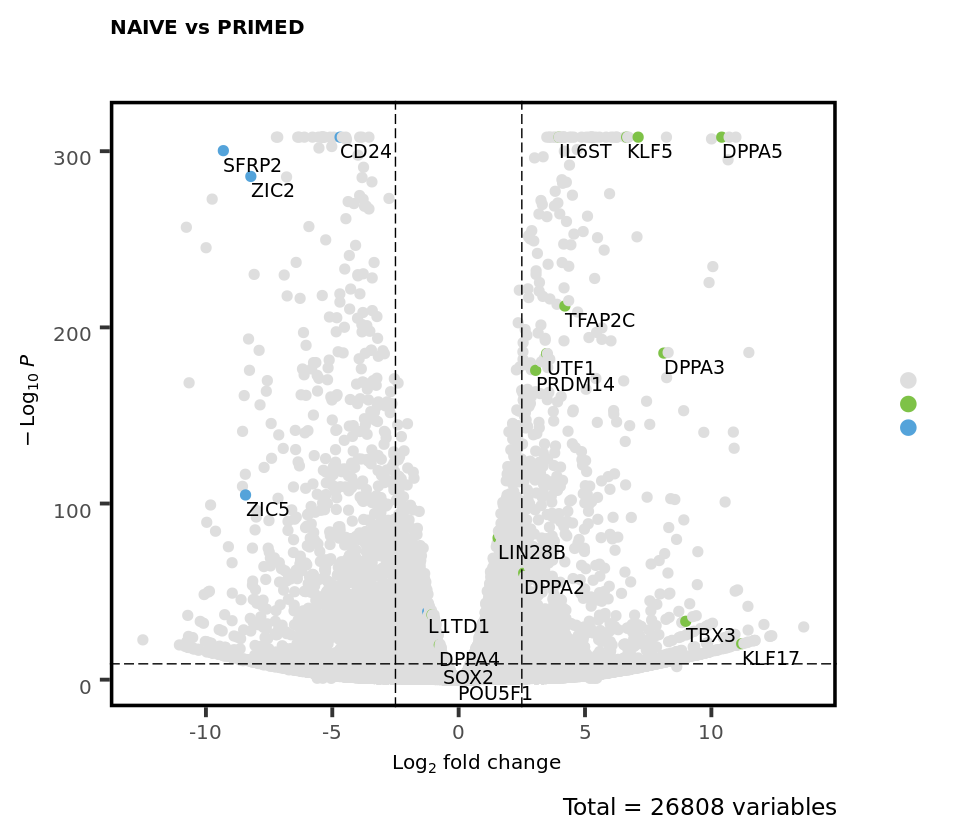

In [49]:
volcano_naive_primed

In [120]:
pdf("Volcano_N_P_S1.pdf",width=8,height=7,useDingbats = FALSE)
plot(volcano_naive_primed)
dev.off()

png 
  2